In [107]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np

import os
import joblib

from tqdm import tqdm
import boto3
client = boto3.client('s3')

# Code from https://github.com/derekgreene/dynamic-nmf
%run Greene_dnmf.py

# get procedural stop words
%run procedural_stop_words.py


from plotnine import ggplot, aes, geoms, scales
from plotnine import theme, element_blank,element_line,element_rect,element_text, ylim, xlim, annotate, ggtitle

In [48]:
custom_theme = theme(panel_background=element_blank(),
                    axis_line=element_line(),
                    figure_size=(12,5))

In [3]:
with open('Official_TopicModel_80k.pkl','rb') as File:
    models = joblib.load(File)
    
all_df = pd.read_csv('All_speeches_labelled.csv')

In [4]:
def term_rankings(H,terms,ntop):
    term_rankings = []
    for topic_index in range(H.shape[0]):
        top_indices = np.argsort(H[topic_index,:])[::-1]
        term_ranking = [terms[i] for i in top_indices[:ntop]]
        term_rankings.append(term_ranking)
    return term_rankings

In [5]:
def select_data(year):
    sub_df = all_df.loc[all_df.year_x == year]
    model = [mod for mod in models['window_models'] if mod['year'] == year][0]
    
    Y = [1 if i == 'D' else 0 for i in sub_df.party_y]
    X = model['W']
    
    
    return X,Y,sub_df[['party_y','speaker']]

In [19]:
def fit_model(X,Y,df):
    _models = []
    for C in np.arange(0.1,1,0.1):
        mod = LogisticRegression(penalty='l1',solver='liblinear',class_weight='balanced',C=C)
        mod.fit(X,Y)
        predictions = mod.predict(X)
        speech_accuracy = sum([1 for ix,i in enumerate(predictions) if i == Y[ix]])/len(Y)
        
        speech_probs = [i[1] for i in mod.predict_proba(X)]
        df['prob_party'] = speech_probs
        
        partisan_assigned = df.groupby('speaker').prob_party.mean().reset_index()
        partisan_assigned['predicted_party'] = partisan_assigned.prob_party.apply(lambda x: 'D' if x > 0.5 else 'R')
        correct_speaker = sum(df.groupby('speaker').party_y.first().reset_index()
                             .merge(partisan_assigned,on='speaker',how='inner')
                             .apply(lambda x: 1 if x.party_y == x.predicted_party else 0,1))

        speaker_accuracy = correct_speaker/len(partisan_assigned)
        _models.append({"C":C,'speech_accuracy':speech_accuracy,'speaker_accuracy':speaker_accuracy})
    return pd.DataFrame(_models)

In [38]:
records = []
for year in tqdm(range(1983,2017)):
    X,Y,df = select_data(year)
    mod_df = fit_model(X,Y,df)
    records.append({"year":year,
                    "speaker_accuracy":mod_df.speaker_accuracy.max(),
                    "speech_accuracy":mod_df.speech_accuracy.max()})
    
true_records = pd.DataFrame(records)

100%|██████████| 34/34 [00:44<00:00,  1.31s/it]


### Chance models

In [39]:
records = []
for year in tqdm(range(1983,2017)):
    for i in range(10):
        X,Y,df = select_data(year)
        np.random.shuffle(Y)
        mod_df = fit_model(X,Y,df)
        records.append({"year":year,
                        "speaker_accuracy":mod_df.speaker_accuracy.max(),
                        "speech_accuracy":mod_df.speech_accuracy.max(),
                        "iteration":i
                       })
    
null_records = pd.DataFrame(records)

100%|██████████| 34/34 [06:05<00:00, 10.74s/it]


In [52]:
null_records

,year,speaker_accuracy,speech_accuracy,iteration
0,1983,0.515326,0.571979,0
1,1983,0.595785,0.548278,1
2,1983,0.599617,0.534242,2
3,1983,0.440613,0.533368,3
4,1983,0.590038,0.567815,4
...,...,...,...,...
335,2016,0.573913,0.537247,5
336,2016,0.573913,0.537247,6
337,2016,0.573913,0.537247,7
338,2016,0.573913,0.538269,8


In [108]:
combo = pd.concat([null_records,true_records])
combo.loc[combo.iteration.isnull(),'type']  = 'actual'
combo.loc[-combo.iteration.isnull(),'type']  = 'null'
combo.loc[combo.iteration.isnull(),'iteration']  = 11

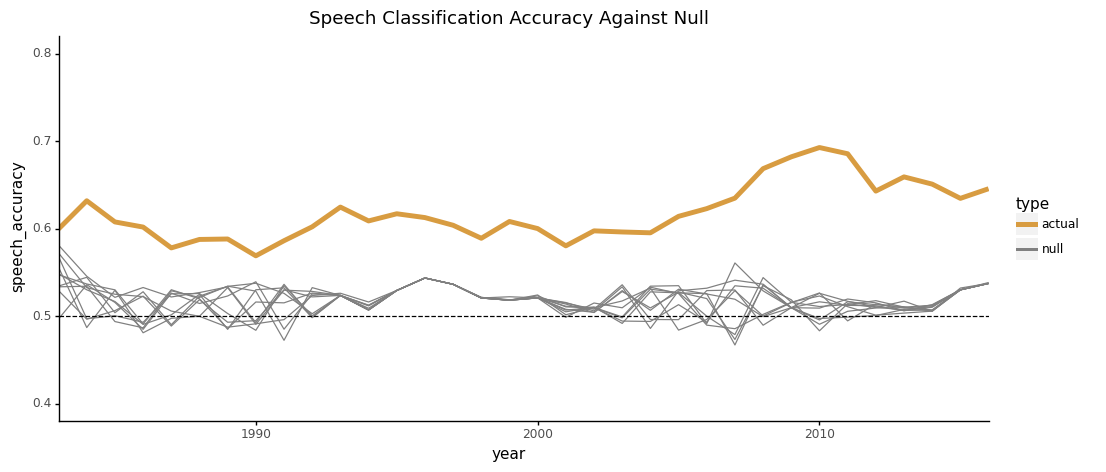

<ggplot: (8750115197935)>

In [114]:
(
    ggplot(combo, aes(x = 'year',y='speech_accuracy',group='iteration',color='type')) + 
    geoms.geom_line(aes(size='type')) + 
    custom_theme +
    ylim(0.4,0.8) +
    scales.scale_color_manual(values=['#d89c41','grey']) +
    scales.scale_size_manual(values=[2,0.5]) + 
    annotate('segment',x=1983,xend=2016,y=0.5,yend=0.5,linetype='dashed') +
    scales.scale_x_continuous(expand=[0,0]) +
    ggtitle('Speech Classification Accuracy Against Null')
)

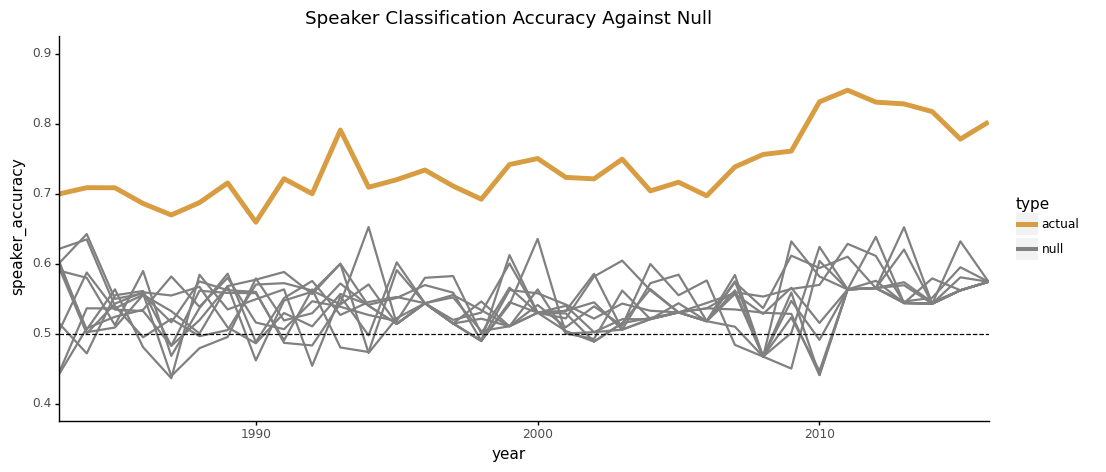

<ggplot: (-9223363286747925872)>

In [116]:
(
    ggplot(combo, aes(x = 'year',y='speaker_accuracy',group='iteration',color='type')) + 
    geoms.geom_line(aes(size='type')) + 
    custom_theme +
    ylim(0.4,0.9) +
    scales.scale_color_manual(values=['#d89c41','grey']) +
    scales.scale_size_manual(values=[2,0.9]) + 
    annotate('segment',x=1983,xend=2016,y=0.5,yend=0.5,linetype='dashed') +
    scales.scale_x_continuous(expand=[0,0]) +
    ggtitle('Speaker Classification Accuracy Against Null')
)

### Bootstrapped models